/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in reciprocal


Streaming output truncated to the last 5000 lines.

 time step = 4182, time=5.227500000000001, unsteadiness = 0.006355736030186353

 time step = 4183, time=5.228750000000001, unsteadiness = 0.006352631549075282

 time step = 4184, time=5.230000000000001, unsteadiness = 0.006350777659916428

 time step = 4185, time=5.231250000000001, unsteadiness = 0.006344196920984867

 time step = 4186, time=5.232500000000001, unsteadiness = 0.006340431260334899

 time step = 4187, time=5.2337500000000015, unsteadiness = 0.006336206809542943

 time step = 4188, time=5.235000000000001, unsteadiness = 0.006329721589297398

 time step = 4189, time=5.236250000000001, unsteadiness = 0.00632549200734328

 time step = 4190, time=5.237500000000001, unsteadiness = 0.0063190389415532225

 time step = 4191, time=5.238750000000001, unsteadiness = 0.0063156730911687045

 time step = 4192, time=5.240000000000001, unsteadiness = 0.006307272639055616

 time step = 4193, time=5.241250000000001, unsteadiness = 0.006301

(0.05, 0.95, 0.05, 0.95)

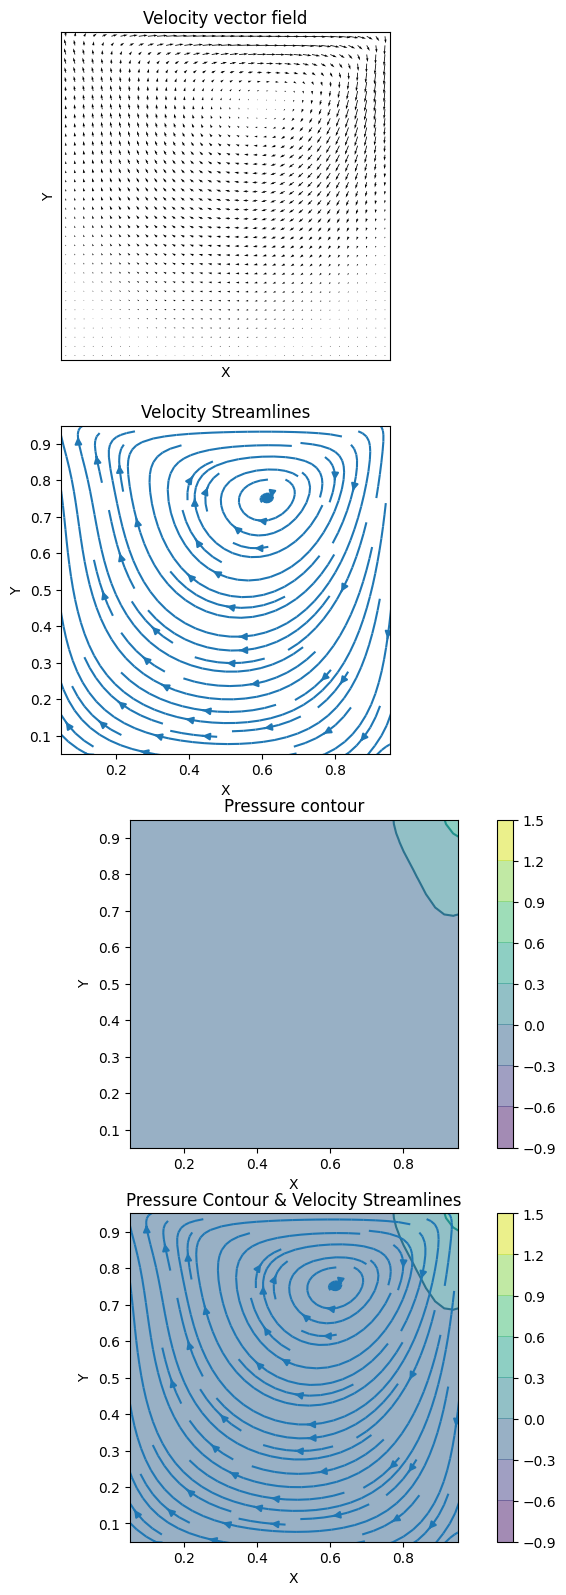

In [ ]:
import numpy as np
import math 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Parameters
L=np.array([1.,1.]);
imax=42;jmax=42;  
Re=100.;rho=1.;U0=1.;mu=rho*U0*min(L)/Re; 
Dx=[L[0]/(imax-2),L[1]/(jmax-2)]

#Initialization
x=np.zeros(shape=[max(imax,jmax),2])
dx=np.zeros(shape=[max(imax-1,jmax-1),2])
b=np.zeros(shape=[imax-1,jmax-1])
c=np.zeros(shape=[imax-1,jmax-1])
m_p=np.zeros(shape=[imax-1,jmax-1,2])
S_p_m=np.zeros(shape=[imax-1,jmax-1])
m_c=np.zeros(shape=[imax-1,jmax-1,2])
S_c_m=np.zeros(shape=[imax-1,jmax-1])

u=np.zeros(shape=([imax,jmax,2]))
u_old=np.zeros(shape=([imax,jmax,2]))
u_p=np.zeros(shape=([imax,jmax,2]))
p=np.zeros(shape=[imax,jmax])
p_old=np.zeros(shape=[imax,jmax])
p_p=np.zeros(shape=[imax,jmax])
p_c=np.zeros(shape=[imax,jmax])
p_c_old=np.zeros(shape=[imax,jmax])

m=np.zeros(shape=[imax-1,jmax-1,2,2])
m_plus=np.zeros(shape=[imax-1,jmax-1,2,2])
m_minus=np.zeros(shape=[imax-1,jmax-1,2,2])
a=np.zeros(shape=[imax-1,jmax-1,2,2])
d=np.zeros(shape=[imax-1,jmax-1,2,2])
A=np.zeros(shape=[imax-1,jmax-1,2])
D=np.zeros(shape=[imax-1,jmax-1,2])
S=np.zeros(shape=[imax-1,jmax-1,2])

#Grid Generation
k=0 #defines axis of variable 0=x,1=y
for i in range(1,imax): 
    if i==1 or i==imax-1:x[i,k] = x[i-1,k]+ Dx[k]/2; 
    else: x[i,k] = x[i-1,k]+ Dx[k]; 
k=1
for j in range(1,jmax):
    if j==1 or j==jmax-1: x[j,k] = x[j-1,k]+ Dx[k]/2; 
    else: x[j,k] = x[j-1,k]+ Dx[k];  

k=0; dx[range(0,imax-1),k]=x[range(1,imax),k]-x[range(0,imax-1),k]
k=1; dx[range(0,jmax-1),k]=x[range(1,jmax),k]-x[range(0,jmax-1),k]
dx_inv=np.reciprocal(dx); dx_inv[np.isinf(dx_inv)]=0

#Step 4 Dirichlet BC 
k=0; u[0:imax-1,0,k] = 0; u[0:imax-1,jmax-1,k] = 1; u[0,1:jmax-1,k] = 0; u[imax-2,1:jmax-1,k]=0; #x-velocity BC
k=1; u[0,0:jmax-1,k]= 0; u[imax-1,0:jmax-1,k]=0; u[1:imax-1,0,k]=0; u[1:imax-1,jmax-2,k]=0; #y-velocity BC

#Step 5 Time step criterion
eps_st=10**-3;  eps=10**-8;  #convergence criteria
dt_adv=(abs(U0)/Dx[0])**-1; dt_diff=np.power(mu/rho*(sum(np.power(Dx,-2))),-1) 
dt_stab=min(dt_adv,dt_diff); dt=0.05*dt_stab; tau=U0*dt/max(L); #time step
ts_count=0; unsteadiness=1;
dt_diff
for i in range(1,imax-1):
    for j in range(1,jmax-1):
        b[i,j]=dt*((1/dx[i,0]+1/dx[i-1,0])*Dx[1]+(1/dx[j,1]+1/dx[j-1,1])*Dx[0]);
c=np.reciprocal(b); c[np.isinf(c)]=0

#Predictor Step
while(unsteadiness>eps_st): # final iteration for convergence 
    ts_count=ts_count+1;
    print(f"\n time step = {ts_count}, time={ts_count*dt}, unsteadiness = {unsteadiness}")       

    #Non-Dirichlet BC
    p[0:imax-1,0]=p[0:imax-1,1]; 
    p[0:imax-1,jmax-1]=p[0:imax-1,jmax-2]; 
    p[0,0:jmax-1]=p[1,0:jmax-1]; 
    p[imax-1,0:jmax-1]=p[imax-2,0:jmax-1];

    u_old=np.copy(u);u_p=np.copy(u); p_old=np.copy(p);p_p=np.copy(p);

    #Step 6a.............................................................................
    k=0;l=0;
    m[0:imax-2,1:jmax-1,k,l]=(u[1:imax-1,1:jmax-1,k]+u[0:imax-2,1:jmax-1,k])/2*rho;
    m_plus=np.copy(m); m_plus[m_plus<0]=0; m_minus=np.copy(m); m_minus[m_minus>0]=0;
    a[0:imax-2,1:jmax-1,k,l]=m_plus[0:imax-2,1:jmax-1,k,l]*u[0:imax-2,1:jmax-1,k]+m_minus[0:imax-2,1:jmax-1,k,l]*u[1:imax-1,1:jmax-1,k];
    d[0:imax-2,1:jmax-1,k,l]=mu*(u[1:imax-1,1:jmax-1,k]-u[0:imax-2,1:jmax-1,k])/Dx[l];

    k=1;l=1;
    m[1:imax-1,0:jmax-2,k,l]=(u[1:imax-1,1:jmax-1,k]+u[1:imax-1,0:jmax-2,k])/2*rho;
    m_plus=np.copy(m); m_plus[m_plus<0]=0; m_minus=np.copy(m); m_minus[m_minus>0]=0;
    a[1:imax-1,0:jmax-2,k,l]=m_plus[1:imax-1,0:jmax-2,k,l]*u[1:imax-1,0:jmax-2,k]+m_minus[1:imax-1,0:jmax-2,k,l]*u[1:imax-1,1:jmax-1,k];
    d[1:imax-1,0:jmax-2,k,l]=mu*(u[1:imax-1,1:jmax-1,k]-u[1:imax-1,0:jmax-2,k])/Dx[l];

    #Step 6b.............................................................................
    k=0;l=1;
    m[1:imax-2,0:jmax-1,k,l]=(u[2:imax-1,0:jmax-1,l]+u[1:imax-2,0:jmax-1,l])/2*rho;
    m_plus=np.copy(m); m_plus[m_plus<0]=0; m_minus=np.copy(m); m_minus[m_minus>0]=0;
    a[1:imax-2,0:jmax-1,k,l]=m_plus[1:imax-2,0:jmax-1,k,l]*u[1:imax-2,0:jmax-1,k]+m_minus[1:imax-2,0:jmax-1,k,l]*u[1:imax-2,1:jmax,k];
    d[1:imax-2,0:jmax-1,k,l]=mu*(u[1:imax-2,1:jmax,k]-u[1:imax-2,0:jmax-1,k])/Dx[l];   
    d[1:imax-2,jmax-2,k,l]=2*d[1:imax-2,jmax-2,k,l]; d[1:imax-2,0,k,l]=2*d[1:imax-2,0,k,l];

    k=1;l=0;
    m[0:imax-1,1:jmax-2,k,l]=(u[0:imax-1,2:jmax-1,l]+u[0:imax-1,1:jmax-2,l])/2*rho;
    m_plus=np.copy(m); m_plus[m_plus<0]=0; m_minus=np.copy(m); m_minus[m_minus>0]=0;
    a[0:imax-1,1:jmax-2,k,l]=m_plus[0:imax-1,1:jmax-2,k,l]*u[0:imax-1,1:jmax-2,k]+m_minus[0:imax-1,1:jmax-2,k,l]*u[1:imax,1:jmax-2,k];
    d[0:imax-1,1:jmax-2,k,l]=mu*(u[1:imax,1:jmax-2,k]-u[0:imax-1,1:jmax-2,k])/Dx[l];   
    d[imax-2,1:jmax-2,k,l]=2*d[imax-2,1:jmax-2,k,l]; d[0,1:jmax-2,k,l]=2*d[0,1:jmax-2,k,l];

    #Step 6c.............................................................................
    k=0;
    A[1:imax-2,1:jmax-1,k]=(a[1:imax-2,1:jmax-1,k,0]-a[0:imax-3,1:jmax-1,k,0])*Dx[1]+(a[1:imax-2,1:jmax-1,k,1]-a[1:imax-2,0:jmax-2,k,1])*Dx[0];
    D[1:imax-2,1:jmax-1,k]=(d[1:imax-2,1:jmax-1,k,0]-d[0:imax-3,1:jmax-1,k,0])*Dx[1]+(d[1:imax-2,1:jmax-1,k,1]-d[1:imax-2,0:jmax-2,k,1])*Dx[0];
    S[1:imax-2,1:jmax-1,k]=(p[1:imax-2,1:jmax-1]-p[2:imax-1,1:jmax-1])*Dx[1];
    u_p[1:imax-2,1:jmax-1,k]=u[1:imax-2,1:jmax-1,k]+dt/(rho*Dx[0]*Dx[1])*(D[1:imax-2,1:jmax-1,k]-A[1:imax-2,1:jmax-1,k]+S[1:imax-2,1:jmax-1,k]);
    m_p[1:imax-2,1:jmax-1,k]=rho*u_p[1:imax-2,1:jmax-1,k];
    m_p[0,1:jmax-1,k]=rho*u[0,1:jmax-1,k]; m_p[imax-2,1:jmax-1,k]=rho*u[imax-2,1:jmax-1,k];

    k=1;
    A[1:imax-1,1:jmax-2,k]=(a[1:imax-1,1:jmax-2,k,0]-a[0:imax-2,1:jmax-2,k,0])*Dx[1]+(a[1:imax-1,1:jmax-2,k,1]-a[1:imax-1,0:jmax-3,k,1])*Dx[0];
    D[1:imax-1,1:jmax-2,k]=(d[1:imax-1,1:jmax-2,k,0]-d[0:imax-2,1:jmax-2,k,0])*Dx[1]+(d[1:imax-1,1:jmax-2,k,1]-d[1:imax-1,0:jmax-3,k,1])*Dx[0];
    S[1:imax-1,1:jmax-2,k]=(p[1:imax-1,1:jmax-2]-p[1:imax-1,2:jmax-1])*Dx[1];
    u_p[1:imax-1,1:jmax-2,k]=u[1:imax-1,1:jmax-2,k]+dt/(rho*Dx[0]*Dx[1])*(D[1:imax-1,1:jmax-2,k]-A[1:imax-1,1:jmax-2,k]+S[1:imax-1,1:jmax-2,k]);
    m_p[1:imax-1,1:jmax-2,k]=rho*u_p[1:imax-1,1:jmax-2,k];
    m_p[1:imax-1,0,k]=rho*u[1:imax-1,0,k]; m_p[1:imax-1,jmax-2,k]=rho*u[1:imax-1,jmax-2,k];       

    S_p_m[1:imax-1,1:jmax-1]=(m_p[1:imax-1,1:jmax-1,0]-m_p[0:imax-2,1:jmax-1,0])*Dx[1]+(m_p[1:imax-1,1:jmax-1,1]-m_p[1:imax-1,0:jmax-2,1])*Dx[0];
    p_c=np.zeros(shape=[imax,jmax])
    
    #CORRECTOR STEP
    while(np.max(np.abs(S_p_m))>eps):

        p_c_old=np.copy(p_c);                
        p_c[0:imax,0]=p_c[0:imax,1];
        p_c[0:imax,jmax-1]=p_c[0:imax,jmax-2];
        p_c[0,0:jmax]=p_c[1,0:jmax];
        p_c[imax-1,0:jmax]=p_c[imax-2,0:jmax];

        #Step 10
        for i in range(1,imax-1):
            for j in range(1,jmax-1):
                S_c_m[i,j]=-dt*Dx[1]/Dx[0]*((p_c_old[i+1,j]-p_c_old[i,j])-(p_c_old[i,j]-p_c[i-1,j]))-dt*Dx[0]/Dx[1]*((p_c_old[i,j+1]-p_c_old[i,j])-(p_c_old[i,j]-p_c[i,j-1]));
                p_c[i,j]=p_c_old[i,j]-c[i,j]*(S_p_m[i,j]+S_c_m[i,j]);    

        #Step 11        
        k=0;
        for j in range(1,jmax-1):
            m_c[0:imax-1,j,k]=-dt*(p_c[1:imax,j]-p_c[0:imax-1,j])*dx_inv[0:imax-1,k];
        m_p[0:imax-1,1:jmax-1,k]=m_p[0:imax-1,1:jmax-1,k]+m_c[0:imax-1,1:jmax-1,k];
        u_p[0:imax-1,1:jmax-1,k]=m_p[0:imax-1,1:jmax-1,k]/rho;

        k=1;
        for i in range(1,imax-1):
            m_c[i,0:jmax-1,k]=-dt*(p_c[i,1:jmax]-p_c[i,0:jmax-1])*dx_inv[0:jmax-1,k];
        m_p[1:imax-1,0:jmax-1,k]=m_p[1:imax-1,0:jmax-1,k]+m_c[1:imax-1,0:jmax-1,k];
        u_p[1:imax-1,0:jmax-1,k]=m_p[1:imax-1,0:jmax-1,k]/rho;

        # #Step 12 
        S_p_m[1:imax-1,1:jmax-1]=(m_p[1:imax-1,1:jmax-1,0]-m_p[0:imax-2,1:jmax-1,0])*Dx[1]+(m_p[1:imax-1,1:jmax-1,1]-m_p[1:imax-1,0:jmax-2,1])*Dx[0];
        p_p[1:imax-1,1:jmax-1]=p_p[1:imax-1,1:jmax-1]+p_c[1:imax-1,1:jmax-1];

#Step 13   
    p=np.copy(p_p); u=np.copy(u_p); 

#Step 14
    unsteadiness=0;
    unsteadiness=max(unsteadiness,np.max(abs((u-u_old)/tau)));


#Step 15 - Plotting
X,Y = np.meshgrid(x[1:imax-1,0],x[1:jmax-1,1])
fig = plt.figure(figsize = (10,20), dpi = 100)

# Velocity vector-field plot
ax1 = fig.add_subplot(4,1,1)
ax1.quiver(X,Y, np.transpose(u[1:imax-1,1:jmax-1,0]),np.transpose(u[1:imax-1,1:jmax-1,1]))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title("Velocity vector field")
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_aspect('equal')
ax1.axis([0.05, 0.95, 0.05, 0.95])

# Velocity Streamline plot
ax2 = fig.add_subplot(4,1,2)
ax2.streamplot(X,Y, np.transpose(u[1:imax-1,1:jmax-1,0]), np.transpose(u[1:imax-1,1:jmax-1,1]))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title("Velocity Streamlines")
ax2.set_aspect('equal')
ax2.axis([0.05, 0.95, 0.05, 0.95])

# Pressure contour plot
ax3 = fig.add_subplot(4,1,3)
plt.contourf(X,Y, np.transpose(p[1:imax-1,1:jmax-1]), alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X,Y,np.transpose(p[1:imax-1,1:jmax-1]), cmap=cm.viridis)
plt.xlabel('X')
plt.ylabel('Y')
ax3.set_title("Pressure contour")
ax3.set_aspect('equal')
ax3.axis([0.05, 0.95, 0.05, 0.95])

# Combined Plot
ax4 = fig.add_subplot(4,1,4)
plt.contourf(X,Y, np.transpose(p[1:imax-1,1:jmax-1]), alpha=0.5, cmap=cm.viridis)
plt.colorbar()
plt.contour(X,Y,np.transpose(p[1:imax-1,1:jmax-1]), cmap=cm.viridis)
plt.streamplot(X,Y, np.transpose(u[1:imax-1,1:jmax-1,0]), np.transpose(u[1:imax-1,1:jmax-1,1]))
plt.xlabel('X')
plt.ylabel('Y')
ax4.set_title("Pressure Contour & Velocity Streamlines")
ax4.set_aspect('equal')
ax4.axis([0.05, 0.95, 0.05, 0.95])

(0.05, 0.95, 0.05, 0.95)

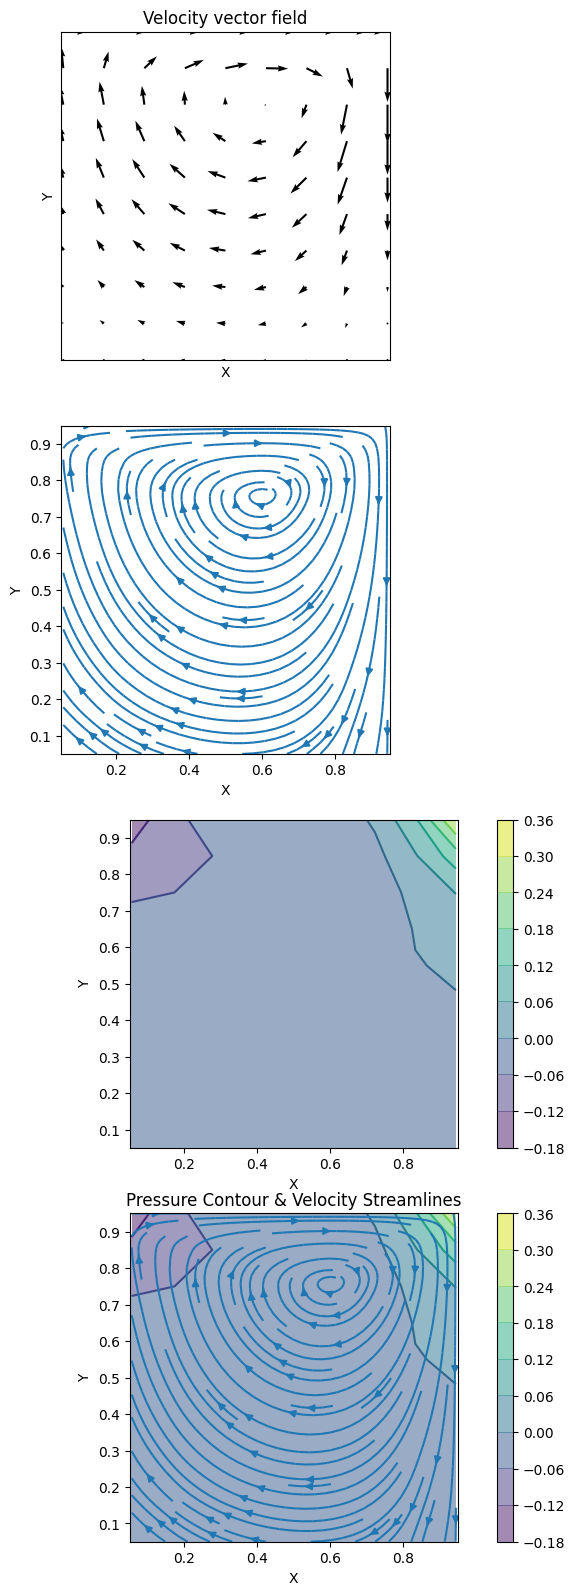

In [ ]:
X,Y = np.meshgrid(x[1:imax-1,0],x[1:jmax-1,1])
fig = plt.figure(figsize = (10,20), dpi = 100)

# Velocity vector-field plot
ax1 = fig.add_subplot(4,1,1)
ax1.quiver(X,Y, np.transpose(u[1:imax-1,1:jmax-1,0]),np.transpose(u[1:imax-1,1:jmax-1,1]))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title("Velocity vector field")
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_aspect('equal')
ax1.axis([0.05, 0.95, 0.05, 0.95])

# Velocity Streamline plot
ax2 = fig.add_subplot(4,1,2)
ax2.streamplot(X,Y, np.transpose(u[1:imax-1,1:jmax-1,0]), np.transpose(u[1:imax-1,1:jmax-1,1]))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_aspect('equal')
ax2.axis([0.05, 0.95, 0.05, 0.95])

# Pressure contour plot
ax3 = fig.add_subplot(4,1,3)
plt.contourf(X,Y, np.transpose(p[1:imax-1,1:jmax-1]), alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X,Y,np.transpose(p[1:imax-1,1:jmax-1]), cmap=cm.viridis)
plt.xlabel('X')
plt.ylabel('Y')
ax3.set_aspect('equal')
ax3.axis([0.05, 0.95, 0.05, 0.95])

# Combined Plot
ax4 = fig.add_subplot(4,1,4)
plt.contourf(X,Y, np.transpose(p[1:imax-1,1:jmax-1]), alpha=0.5, cmap=cm.viridis)
plt.colorbar()
plt.contour(X,Y,np.transpose(p[1:imax-1,1:jmax-1]), cmap=cm.viridis)
plt.streamplot(X,Y, np.transpose(u[1:imax-1,1:jmax-1,0]), np.transpose(u[1:imax-1,1:jmax-1,1]))
plt.xlabel('X')
plt.ylabel('Y')
ax4.set_aspect('equal')
ax4.set_title("Pressure Contour & Velocity Streamlines")
ax4.axis([0.05, 0.95, 0.05, 0.95])